In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt

In [3]:
import os
from skimage.transform import resize
from skimage import io
from skimage import color
import numpy as np
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

import re

from glob import glob

from toolz import first

Using TensorFlow backend.


In [4]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


def get_unet(img_rows=96, img_cols=96):
    inputs = Input((img_rows, img_cols, 1))
    blocks = (img_rows // 32, img_cols // 32)
    conv1 = Conv2D(32, blocks, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, blocks, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])

    return model



In [5]:
keras_model = get_unet(96, 96)

In [15]:
if not os.path.exists('data/carvana-image-masking-challenge'):
    import subprocess
    subprocess.run('pip install kaggle', shell=True, check=True)
    subprocess.run(
        'kaggle competitions download -p data/carvana-image-masking-challenge '
        '-c carvana-image-masking-challenge -f train.zip',
        shell=True, check=True
    )
    subprocess.run(
        'kaggle competitions download -p data/carvana-image-masking-challenge '
        '-c carvana-image-masking-challenge -f train_masks.zip',
        shell=True, check=True
    )
    
    subprocess.run(
        'unzip -o data/carvana-image-masking-challenge/train.zip '
        '-d data/carvana-image-masking-challenge',
        shell=True, check=True
    )

    subprocess.run(
        'unzip -o data/carvana-image-masking-challenge/train_masks.zip '
        '-d data/carvana-image-masking-challenge',
        shell=True, check=True
    )    
    del subprocess

In [27]:
train_files = glob('data/carvana-image-masking-challenge/train/*')
train_files.sort()
train_files = train_files

train_masks_files = glob('data/carvana-image-masking-challenge/train_masks/*')
train_masks_files.sort()

In [22]:
def convert_image(im, output_size=(96, 96)):
    return resize(
        color.rgb2gray(im),
        output_size, mode='constant'
    )

def convert_masks(im, output_size=(96, 96)):
    return (resize(
        im,
        output_size, mode='constant'
    ) > 0).astype(int)

In [40]:
len(train_files)

5088

In [42]:
train = dict()
for t in train_files[:1000]:
    image = re.search(r'[0-9a-f][0-9a-f]+_[0-9][0-9]', t)[0]
    train[image] = convert_image(io.imread(t))

train_masks = dict()
for mask_id in train:
    image = [im for im in train_masks_files if mask_id in im][0]
    train_masks[mask_id] = convert_masks(io.imread(image))

In [ ]:
def whiten(im):
    im = im - im.mean()
    im /= im.std()
    return im
    
train_set = np.array([
  whiten(train[k]) for k in sorted(train)
]).astype(np.float32)[..., None]

train_mask_set = np.array([
  train_masks[k] for k in sorted(train)
]).astype(np.float32)
train_mask_set = train_mask_set[..., None]

In [ ]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

fit_history = keras_model.fit(
    x=train_set, y=train_mask_set,
    batch_size=4, epochs=20, verbose=1, shuffle=True,
    validation_split=0.2,
    callbacks=[model_checkpoint]
)


Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 213s 267ms/step - loss: -0.8847 - dice_coef: 0.8847 - val_loss: -0.8658 - val_dice_coef: 0.8658
Epoch 2/20
800/800 [==============================] - 197s 246ms/step - loss: -0.8905 - dice_coef: 0.8905 - val_loss: -0.8851 - val_dice_coef: 0.8851
Epoch 3/20
800/800 [==============================] - 192s 240ms/step - loss: -0.8932 - dice_coef: 0.8932 - val_loss: -0.8825 - val_dice_coef: 0.8825
Epoch 4/20
800/800 [==============================] - 194s 242ms/step - loss: -0.9001 - dice_coef: 0.9001 - val_loss: -0.8949 - val_dice_coef: 0.8949
Epoch 5/20
656/800 [=======================>......] - ETA: 31s - loss: -0.9030 - dice_coef: 0.9030

1/1 [==============================] - 0s 80ms/step


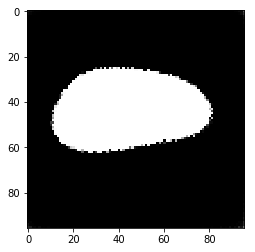

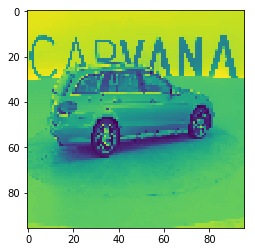

In [35]:
test_index = np.random.randint(0, high=len(train_set))
predict = keras_model.predict(train_set[(test_index,), ...], verbose=1)
plt.imshow(predict.squeeze(), clim=[0, 1], cmap='gray')
plt.figure()
plt.imshow(train_set[test_index].squeeze())

1/1 [==============================] - 0s 93ms/step


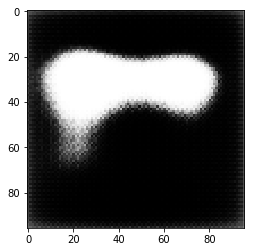

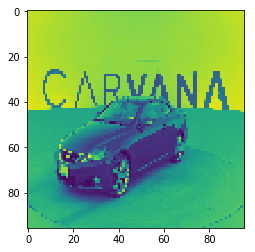

In [39]:
out_of_sample = convert_image(io.imread(train_files[np.random.randint(
    len(train_set),
    len(train_files)
)]))
predict = keras_model.predict(out_of_sample[None, ..., None], verbose=1)
plt.imshow(predict.squeeze(), clim=[0, 1], cmap='gray')
plt.figure()
plt.imshow(out_of_sample)